# Anomaly Detection

# Overview of anomaly detection algorithms on transaction dataset:

* Multivariate Gaussian probability, Auto Encoders, Local Outlier Factor LOF, Robust Covariance (Elliptic Envelope), Isolation Forest

* Anomaly detection systems should NOT prefer supervised ML algorithms as they're highly reliant on labelled training data.
* As the data is very skewed - there are **only 0.17%** fraudulent transactions in the 280k samples -  accuracy is not a good metric: any "model" predicting ALL are normal transactions will have a 99.83% accuracy. 
* Hence, we need to use Recall, Precision and thus their combination, the **F1 score**.
* The models below do not take into account the time sequences for redundancy.
* The training set does NOT include any Fraud, so when the model is exposed to one in Test, it will stand out from the normal transactions. We divided the Frauds into a Validation and Test subsets - F1 score being lower.
* PCA was used only for visualization. PCA is a necessary component of data preprocessing as F1 score turns out very low without it.

* And thus comparison has been drawn between the following on F1 score on **Test**:


### **Multivariate Gaussian prob distribution F1= 0.71** optimizing Epsilon 

### **Auto-encoders F1= 0.53** optimizing Reconstruction Error

### **LOF Local Outlier Factor F1= 0.57** optimizing number of neighbors

### **Robust Covariance (Elliptic Envelope) *F1= 0.80*** optimizing support fraction

### **Isolation Forest F1= 0.47** optimizing num estimators

In [1]:
# IMPORT MODULES

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope

from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [2]:
# LOAD DATA

dfRaw = pd.read_csv('./creditcard.csv')
print(dfRaw.shape)
print(dfRaw.columns)

(284807, 31)
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [3]:
data = dfRaw.copy()
normal_data = data.loc[data["Class"] == 0]
fraud_data = data.loc[data["Class"] == 1]

print("data ", data.shape)
print("normal_data ", normal_data.shape)
print("fraud_data ", fraud_data.shape)
print("Percent fraud ", round(100*492/284807, 3),"%")
print("_"*100)
print(data.head())

data  (284807, 31)
normal_data  (284315, 31)
fraud_data  (492, 31)
Percent fraud  0.173 %
____________________________________________________________________________________________________
   Time        V1        V2        V3        V4        V5        V6        V7   
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599  \
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25   
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539  \
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3 

Mean 88.29102242231328 122.21132113821139
Median 22.0 9.25


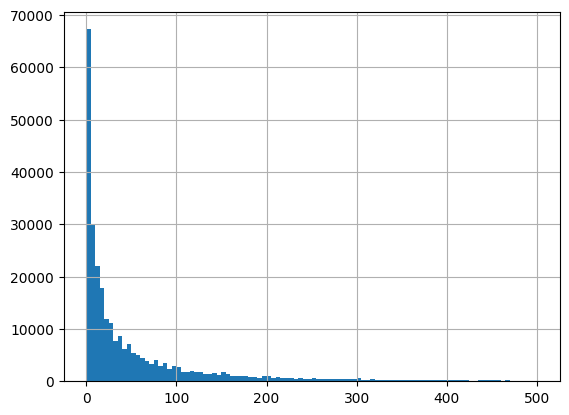

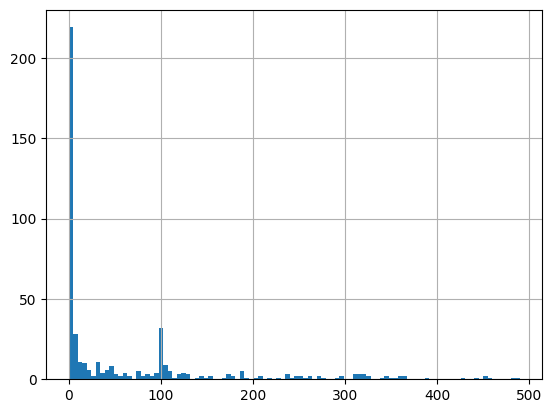

<Figure size 640x480 with 0 Axes>

In [4]:
# PLOT AMOUNT - Norm vs Fraud

normal_data["Amount"].loc[normal_data["Amount"] < 500].hist(bins=100);
plt.figure()
fraud_data["Amount"].loc[fraud_data["Amount"] < 500].hist(bins=100);
plt.figure()
print("Mean", normal_data["Amount"].mean(), fraud_data["Amount"].mean())
print("Median", normal_data["Amount"].median(), fraud_data["Amount"].median())

<Figure size 640x480 with 0 Axes>

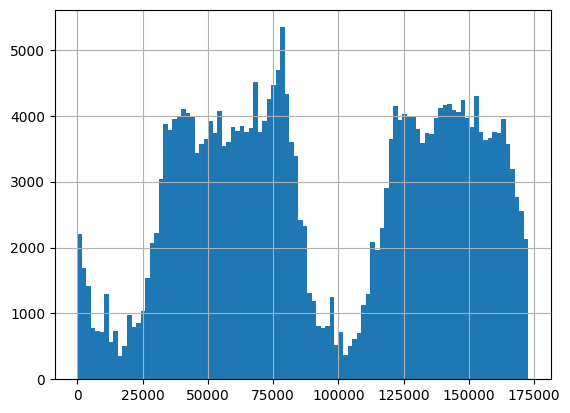

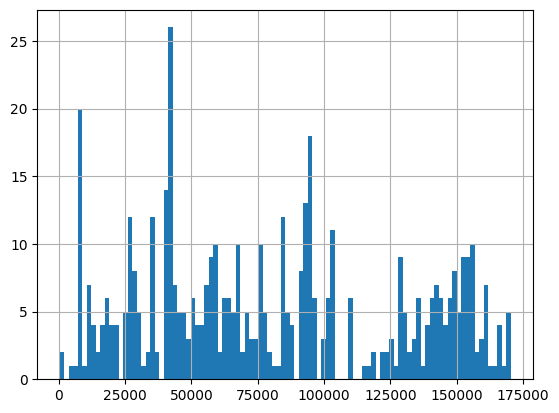

<Figure size 640x480 with 0 Axes>

In [5]:
# PLOT TIME - Norm vs Fraud

normal_data["Time"].hist(bins=100)
plt.figure()
fraud_data["Time"].hist(bins=100)
plt.figure()

<Axes: xlabel='V1', ylabel='Amount'>

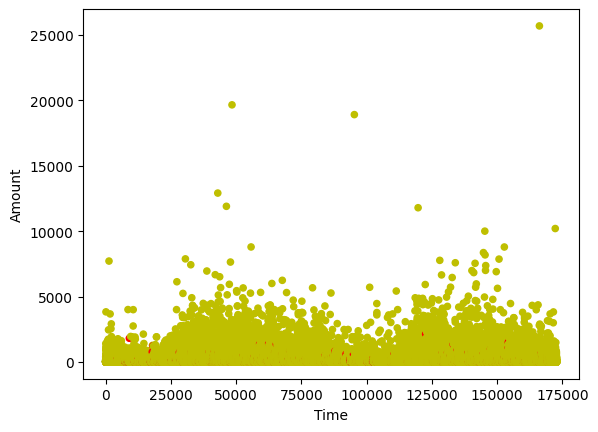

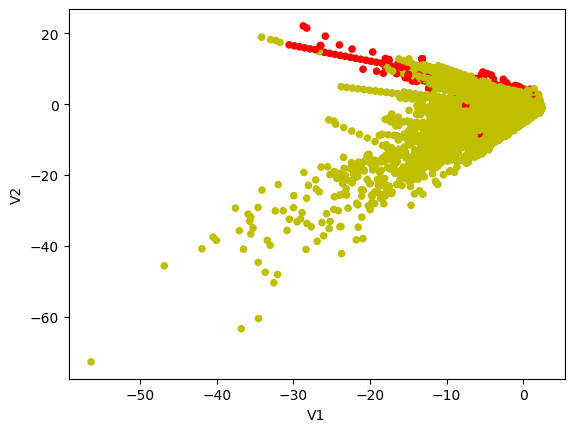

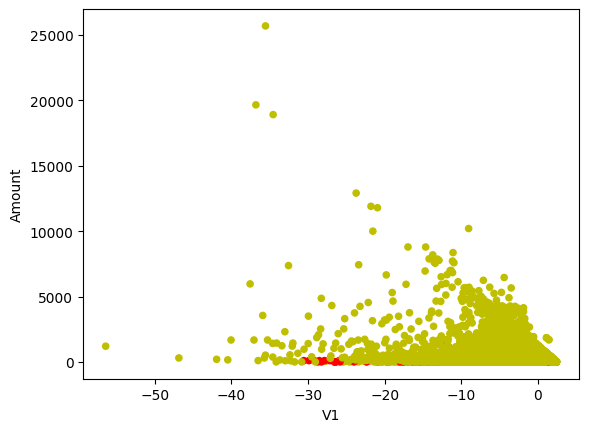

In [6]:
colors = np.where(data["Class"]==1,'r','y')

data.plot.scatter("Time","Amount", c=colors)
data.plot.scatter("V1","V2", c=colors)
data.plot.scatter("V1","Amount", c=colors)


In [7]:
#  SCALER / Normalization

data = dfRaw.copy()
scl = StandardScaler()
all_cols = list(data)[:] 
pca_columns = list(data)[:-1] # all cols without Class
Xcopy = data[pca_columns]
XcopyALL = data[all_cols]
Xscaled = scl.fit_transform(Xcopy)
OnlyClass = data['Class'].values.reshape(-1,1)
data = np.concatenate((Xscaled, OnlyClass), axis=1)
data = pd.DataFrame(data, columns = XcopyALL.columns)

normal_data = data.loc[data["Class"] == 0]
fraud_data = data.loc[data["Class"] == 1]

print("data ", data.shape)
print("normal_data ", normal_data.shape)
print("fraud_data ", fraud_data.shape)
print("Percent fraud ", round(100*492/284807, 4),"%")

data  (284807, 31)
normal_data  (284315, 31)
fraud_data  (492, 31)
Percent fraud  0.1727 %


In [8]:
# Check values are centered around 0 after normalization

print("data['Time'].mean()  ", data['Time'].mean())
print("data['Amount'].mean()  ", data['Amount'].mean())

data['Time'].mean()   -3.065637128659096e-16
data['Amount'].mean()   2.913951958230651e-17


In [9]:
# CREATE the TRAIN and TEST sets
# Fraud data is ONLY in TEST - not in TRAIN

normal_pca_data = normal_data[pca_columns]
fraud_pca_data = fraud_data[pca_columns]

num_test = 75000
shuffled_data = normal_pca_data.sample(frac=1, random_state=1960)[:-num_test].values
X_train = shuffled_data

#X_valid = np.concatenate([shuffled_data[-2*num_test:-num_test], fraud_pca_data[:246]])
#y_valid = np.concatenate([np.zeros(num_test), np.ones(246)])

X_test = np.concatenate([shuffled_data[-num_test:], fraud_pca_data[:]])
y_test = np.concatenate([np.zeros(num_test), np.ones(492)])

print("normal_pca_data ", normal_pca_data.shape)
print("fraud_pca_data", fraud_pca_data.shape)
print("Fraud data only in Test with NONE in the training")
print("X_train ", X_train.shape)
#print("X_valid ", X_valid.shape)
#print("y_valid ", y_valid.shape)
print("X_test ", X_test.shape)
print("y_test ", y_test.shape)

normal_pca_data  (284315, 30)
fraud_pca_data (492, 30)
Fraud data only in Test with NONE in the training
X_train  (209315, 30)
X_test  (75492, 30)
y_test  (75492,)


# Multi-Variate Gaussian Probability Distribution

In [10]:
# Calculate the  prob on train vs test vs fraud data only (no normals at all)

p = multivariate_normal(mean=np.mean(X_train,axis=0), cov=np.cov(X_train.T))

x = p.pdf(X_train)
print("max prob of x on X_train", max(x))
print("mean prob of x on X_train", np.mean(x))
print('-' * 60)
MyTrain = np.mean(x)

x = p.pdf(X_test)
print("max prob of x on X_test", max(x))
print("mean prob of x on X_test", np.mean(x))
print('-' * 60)
MyTest = np.mean(x)

x = p.pdf(fraud_pca_data)
print("max prob of x on fraud_pca_data", max(x))
print("mean prob of x on fraud_pca_data", np.mean(x))
print('-' * 60)

print('Difference between mean prob of Train vs Test ', MyTrain - MyTest)


max prob of x on X_train 2.2552386882104585e-12
mean prob of x on X_train 6.093073190799006e-14
------------------------------------------------------------
max prob of x on X_test 1.778944727619624e-12
mean prob of x on X_test 6.003670188291289e-14
------------------------------------------------------------
max prob of x on fraud_pca_data 9.639574675463923e-14
mean prob of x on fraud_pca_data 1.0508661127411329e-15
------------------------------------------------------------
Difference between mean prob of Train vs Test  8.94030025077172e-16


In [11]:
# Precision = percentage of Fraud caught
# Recall = percentage of those caught that are actually Fraud
# F1 score = Harmonic mean of P & R
# Need to optimize on the hyperparamter of EPSILON

In [12]:
# Find best epsilon re F1 score

x = p.pdf(X_test)

EpsF1 = []

epsilons = [1e-10, 1e-20, 1e-30, 1e-40, 1e-50, 1e-60, 1e-70, 1e-80, 1e-90, 1e-100, 1e-110, 1e-120,
           1e-130, 1e-140, 1e-150, 1e-160, 1e-170, 1e-180, 1e-190, 1e-200, 1e-210, 1e-220, 1e-230, 1e-240]

for e in range(len(epsilons)):
    eps = epsilons[e]
    pred = (x <= eps)
    f = f1_score(y_test, pred, average='binary')
    #print("F1 score on test", round(f,4), " with epsilon ", eps)
    EpsF1.append([eps, round(f,4)])
    
EpsF1df = pd.DataFrame(EpsF1, columns = ['epsilon', 'F1'])
EpsF1df.head()

,epsilon,F1
0,1.000000e-10,0.0130
1,1.000000e-20,0.1143
2,1.000000e-30,0.2772
3,1.000000e-40,0.3767
4,1.000000e-50,0.4399


In [13]:
# Best Epsilon ... Max F1 on test

EpsF1df.loc[EpsF1df['F1'].idxmax()]


epsilon    1.000000e-140
F1          7.139000e-01
Name: 13, dtype: float64

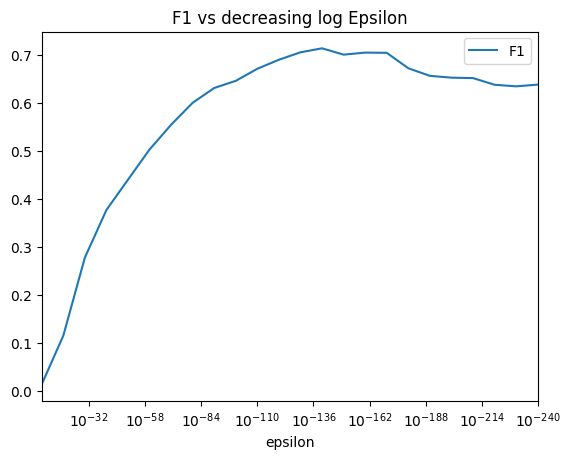

In [14]:
EpsF1df.plot.line("epsilon","F1")
plt.xscale('log')
plt.xlim(1e-10, 1e-240)
plt.title("F1 vs decreasing log Epsilon")
plt.show()

In [15]:
# CONFUSION MATRIX and F1 SCORE on Test with best epsilon

eps = EpsF1df.loc[EpsF1df['F1'].idxmax()]['epsilon']

print("epsilon ", eps)
print("_"*50)
pred = (x<=eps)
CM = confusion_matrix(y_test,pred)
tn, fp, fn, tp = confusion_matrix(y_test,pred).ravel()

print(CM)
print("_"*50)
print("TP ", tp)
print("FP ", fp)
print("TN ", tn)
print("FN ", fn)

epsilon  1e-140
__________________________________________________
[[74820   180]
 [  119   373]]
__________________________________________________
TP  373
FP  180
TN  74820
FN  119


In [16]:
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,
                          normalize=False):
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

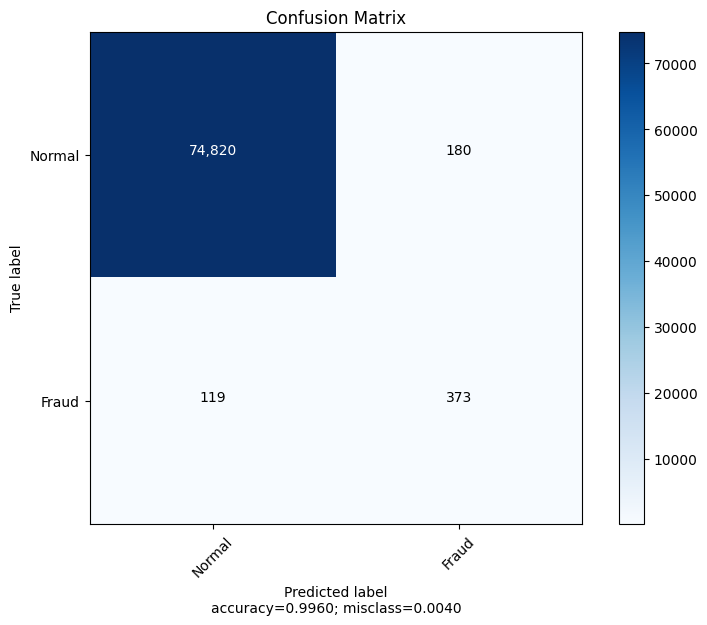

In [17]:
plot_confusion_matrix(CM, 
                      normalize    = False,
                      target_names = ['Normal', 'Fraud'],
                      title        = "Confusion Matrix")

In [18]:
# F1 Score
#print("F1 score", round(f1_score(y_valid,pred, average='binary'), 4))
precision,recall,fbeta_score, support  = precision_recall_fscore_support(y_test,pred, average='binary')
print("precision ", round((precision), 3))
print("recall ", round((recall), 3))
print("F1 score on Test", round((fbeta_score), 3))

precision  0.675
recall  0.758
F1 score on Test 0.714


# PCA = 2 ... Only for visualization ... with or without prior scaling = low F1

In [19]:
#  PCA 

data = dfRaw.copy()
print("Before PCA")
print(data.shape)
print("AFTER PCA")

pca = PCA(n_components = 0.999999) # This way of setting the components = knowledge of the VARIANCE loss during PCA

all_cols = list(data)[:] 
pca_columns = list(data)[:-1] 
Xcopy = data[pca_columns]
XcopyALL = data[all_cols]
dataPostPCA = pca.fit_transform(Xcopy)
OnlyClass = data['Class'].values.reshape(-1,1)
data = np.concatenate((dataPostPCA, OnlyClass), axis=1)
data = pd.DataFrame(data, columns = [0,1,'Class'])

normal_data = data.loc[data["Class"] == 0]
fraud_data = data.loc[data["Class"] == 1]

print(data.shape)
print("data ", data.shape)
print("normal_data ", normal_data.shape)
print("fraud_data ", fraud_data.shape)
print("Percent fraud ", round(100*492/284807, 4),"%")

#print(data.head)

Before PCA
(284807, 31)
AFTER PCA
(284807, 3)
data  (284807, 3)
normal_data  (284315, 3)
fraud_data  (492, 3)
Percent fraud  0.1727 %


# For viz AFTER Scaling and PCA

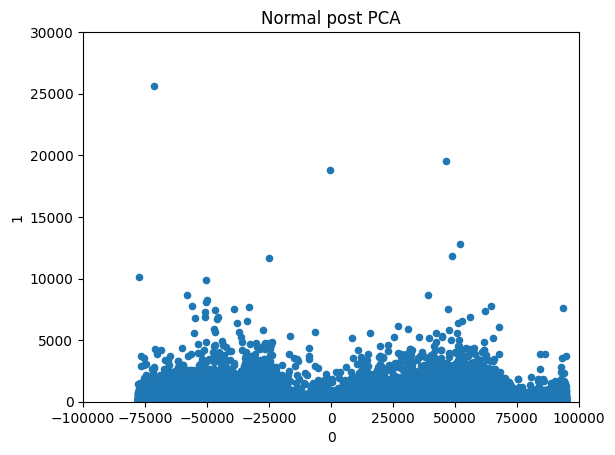

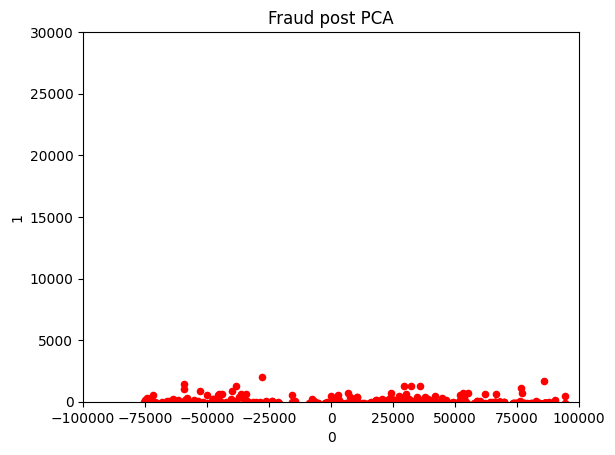

In [20]:
#postPCA = pd.DataFrame(normal_data.sample(10000))
postPCA = pd.DataFrame(data)

postPCA.plot.scatter(0,1)
plt.xlim(-100000, 100000)
plt.ylim(0, 30000)
plt.title("Normal post PCA")
plt.show()

postPCA = pd.DataFrame(fraud_data)

postPCA.plot.scatter(0,1, c='r')
plt.xlim(-100000, 100000)
plt.ylim(0, 30000)
plt.title("Fraud post PCA")
plt.show()

In [21]:
normal_data = normal_data.drop('Class', axis=1)
fraud_data = fraud_data.drop('Class', axis=1)

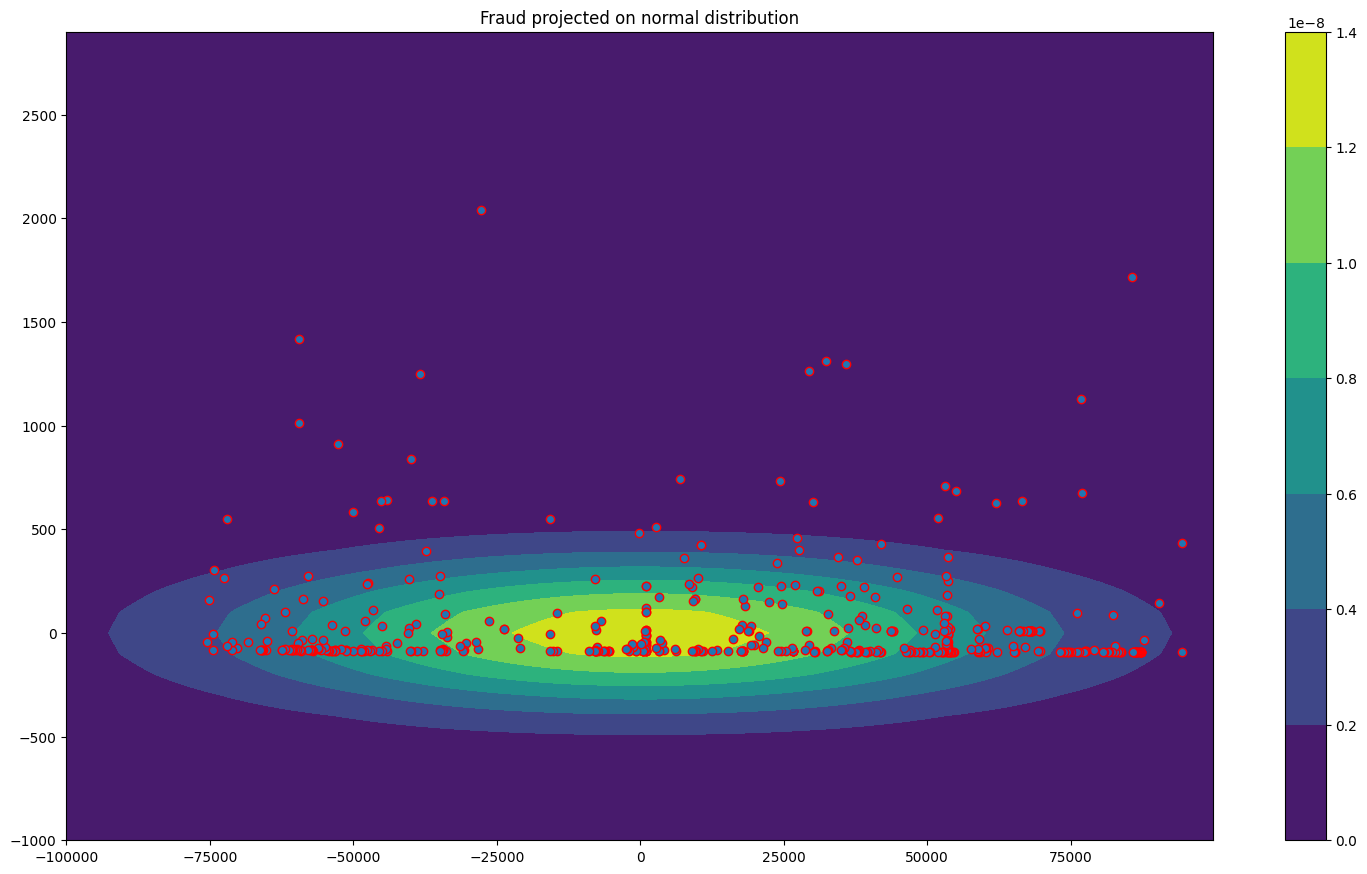

In [22]:
# View the FRAUD on a 2 dims (Post PCA) Guassian distribution of the normal data
# Reducing from 30 dims to 2 - helps with the visualization but surely doesn't help with separating the Fraud from the Normal

x, y = np.mgrid[-100000:100000:100, -1000:3000:100] 
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
rv = multivariate_normal(mean=np.mean(normal_data,axis=0), cov=np.cov(normal_data.T)) # mean and covariance matrix for 2 dims dataset

fig, ax = plt.subplots()
cs = ax.contourf(x, y, rv.pdf(pos))
cbar = fig.colorbar(cs)
plt.title("Fraud projected on normal distribution")
plt.scatter(fraud_data[0],fraud_data[1], edgecolor="r") # Location on chart of the anomaly points
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
#plt.show()

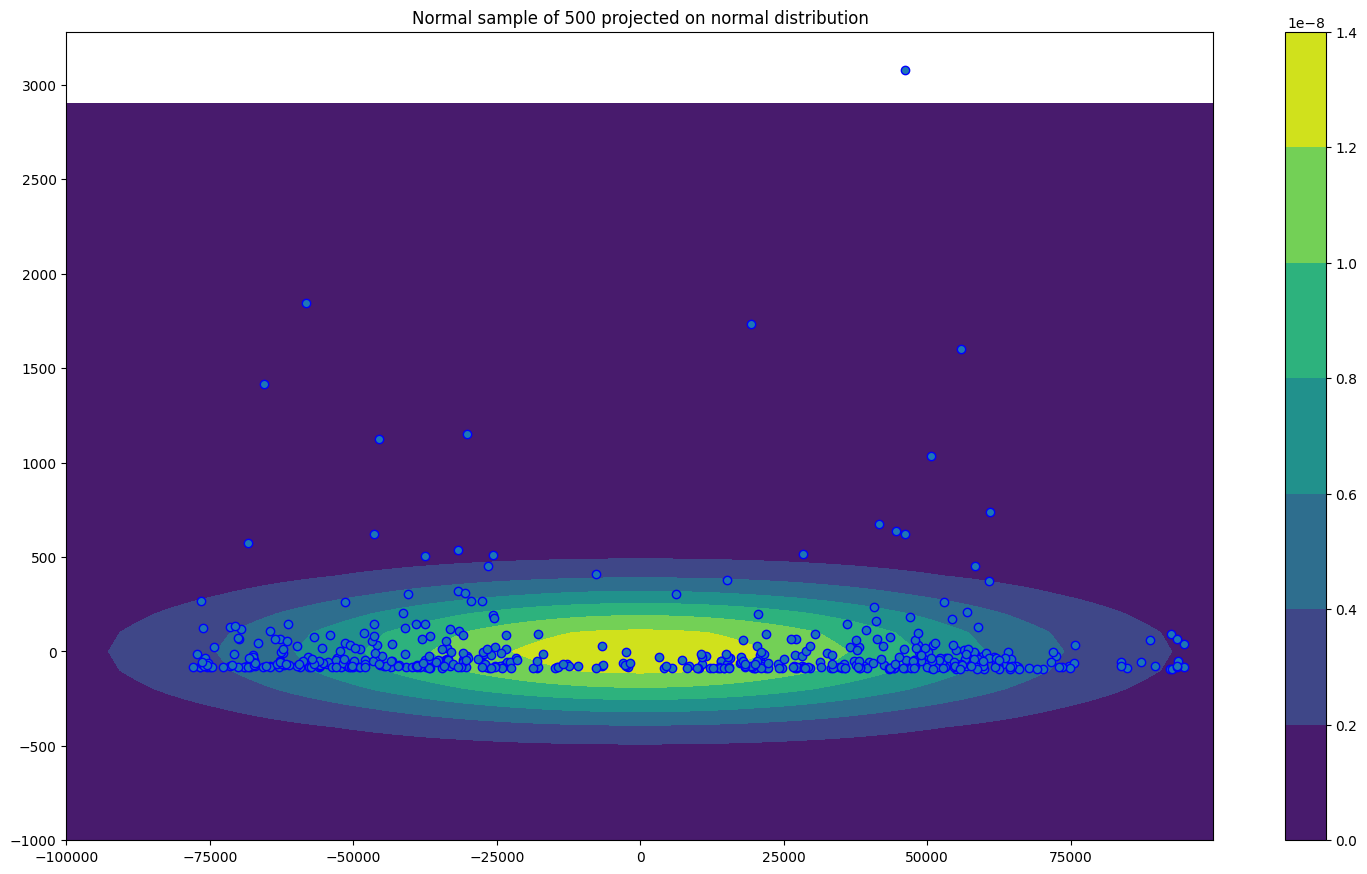

In [23]:
# View some NORMAL on a 2 dims (Post PCA) Guassian distribution of the normal data
# Reducing from 30 dims to 2 - helps with the visualization but surely doesn't help with separating the Fraud from the Normal

SampleNormal = normal_data.sample(500)

x, y = np.mgrid[-100000:100000:100, -1000:3000:100] 
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
rv = multivariate_normal(mean=np.mean(normal_data,axis=0), cov=np.cov(normal_data.T)) # mean and covariance matrix for 2 dims dataset

fig, ax = plt.subplots()
cs = ax.contourf(x, y, rv.pdf(pos))
cbar = fig.colorbar(cs)
plt.title("Normal sample of 500 projected on normal distribution")
plt.scatter(SampleNormal[0],SampleNormal[1], edgecolor="b") # Location on chart of the anomaly points
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
#plt.show()

In [24]:
data = dfRaw.copy()

print("Before PCA")
print(data.shape)
print("AFTER PCA")

pca = PCA(n_components = 0.999999) 

all_cols = list(data)[:] 
pca_columns = list(data)[:-1] 
Xcopy = data[pca_columns]
XcopyALL = data[all_cols]
dataPostPCA = pca.fit_transform(Xcopy)
OnlyClass = data['Class'].values.reshape(-1,1)
data = np.concatenate((dataPostPCA, OnlyClass), axis=1)
data = pd.DataFrame(data, columns = [0,1,'Class'])

normal_data = data.loc[data["Class"] == 0]
fraud_data = data.loc[data["Class"] == 1]

print(data.shape)
print("data ", data.shape)
print("normal_data ", normal_data.shape)
print("fraud_data ", fraud_data.shape)
print("Percent fraud ", round(100*492/284807, 4),"%")

Before PCA
(284807, 31)
AFTER PCA
(284807, 3)
data  (284807, 3)
normal_data  (284315, 3)
fraud_data  (492, 3)
Percent fraud  0.1727 %


In [25]:
# CREATE the TRAIN and TEST sets
# Fraud data is ONLY in TEST - not in TRAIN

normal_pca_data = normal_data.drop('Class',axis=1)
fraud_pca_data = fraud_data.drop('Class',axis=1)

num_test = 75000
shuffled_data = normal_pca_data.sample(frac=1, random_state=1960)[:-num_test].values
X_train = shuffled_data

#X_valid = np.concatenate([shuffled_data[-2*num_test:-num_test], fraud_pca_data[:246]])
#y_valid = np.concatenate([np.zeros(num_test), np.ones(246)])

X_test = np.concatenate([shuffled_data[-num_test:], fraud_pca_data[:]])
y_test = np.concatenate([np.zeros(num_test), np.ones(492)])

print("normal_pca_data ", normal_pca_data.shape)
print("fraud_pca_data", fraud_pca_data.shape)
print("Fraud data only in Test with NONE in the training")
print("X_train ", X_train.shape)
#print("X_valid ", X_valid.shape)
#print("y_valid ", y_valid.shape)
print("X_test ", X_test.shape)
print("y_test ", y_test.shape)

normal_pca_data  (284315, 2)
fraud_pca_data (492, 2)
Fraud data only in Test with NONE in the training
X_train  (209315, 2)
X_test  (75492, 2)
y_test  (75492,)


In [26]:
# Calculate the  prob on train vs test vs fraud data only (no normals at all)

p = multivariate_normal(mean=np.mean(X_train,axis=0), cov=np.cov(X_train.T))

x = p.pdf(X_train)
print("max prob of x on X_train", max(x))
print("mean prob of x on X_train", np.mean(x))
print('-' * 60)
MyTrain = np.mean(x)

x = p.pdf(X_test)
print("max prob of x on X_test", max(x))
print("mean prob of x on X_test", np.mean(x))
print('-' * 60)
MyTest = np.mean(x)

x = p.pdf(fraud_pca_data)
print("max prob of x on fraud_pca_data", max(x))
print("mean prob of x on fraud_pca_data", np.mean(x))
print('-' * 60)

print('Difference between mean prob of Train vs Test ', MyTrain - MyTest)

max prob of x on X_train 1.369378776781379e-08
mean prob of x on X_train 8.169867741057095e-09
------------------------------------------------------------
max prob of x on X_test 1.3692169625512559e-08
mean prob of x on X_test 8.157129019234439e-09
------------------------------------------------------------
max prob of x on fraud_pca_data 1.368315208328899e-08
mean prob of x on fraud_pca_data 7.468033220044317e-09
------------------------------------------------------------
Difference between mean prob of Train vs Test  1.2738721822656689e-11


In [27]:
# Find best epsilon re F1 score

x = p.pdf(X_test)

EpsF1 = []

epsilons = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]

for e in range(len(epsilons)):
    eps = epsilons[e]
    pred = (x <= eps)
    f = f1_score(y_test, pred, average='binary')
    #print("F1 score on test", round(f,4), " with epsilon ", eps)
    EpsF1.append([eps, round(f,4)])
    
EpsF1df = pd.DataFrame(EpsF1, columns = ['epsilon', 'F1'])
EpsF1df.head()

,epsilon,F1
0,0.10000,0.013
1,0.01000,0.013
2,0.00100,0.013
3,0.00010,0.013
4,0.00001,0.013


In [28]:
# Best Epsilon ... Max F1 on test

EpsF1df.loc[EpsF1df['F1'].idxmax()]

epsilon    1.000000e-09
F1         2.170000e-02
Name: 8, dtype: float64

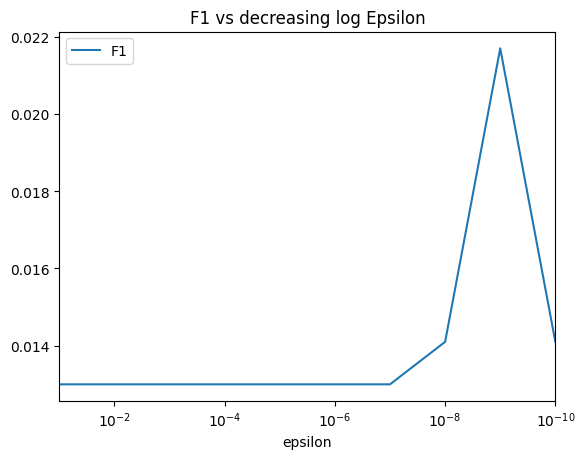

In [29]:
EpsF1df.plot.line("epsilon","F1")
plt.xscale('log')
plt.xlim(1e-1, 1e-10)
plt.title("F1 vs decreasing log Epsilon")
plt.show()

# Auto Encoders

* The idea is to use the Reconstruction Error as the limit to separate between Normal (low reconstruction error) and Fraud anomalies (high reconstruction errors)
* Reconstruction error is the MSE between the input X_train and the output of the autoencoder which has the same dimensions as X_train.
* Not to be confused with the error between a prediction and the true label

In [30]:
#  SCALER / Normalization

data = dfRaw.copy()
scl = StandardScaler()
all_cols = list(data)[:] 
pca_columns = list(data)[:-1] # all cols without Class
Xcopy = data[pca_columns]
XcopyALL = data[all_cols]
Xscaled = scl.fit_transform(Xcopy)
OnlyClass = data['Class'].values.reshape(-1,1)
data = np.concatenate((Xscaled, OnlyClass), axis=1)
data = pd.DataFrame(data, columns = XcopyALL.columns)

normal_data = data.loc[data["Class"] == 0]
fraud_data = data.loc[data["Class"] == 1]

print("data ", data.shape)
print("normal_data ", normal_data.shape)
print("fraud_data ", fraud_data.shape)
print("Percent fraud ", round(100*492/284807, 4),"%")

data  (284807, 31)
normal_data  (284315, 31)
fraud_data  (492, 31)
Percent fraud  0.1727 %


In [31]:
# Check values are centered around 0 after normalization

print("data['Time'].mean()  ", data['Time'].mean())
print("data['Amount'].mean()  ", data['Amount'].mean())

data['Time'].mean()   -3.065637128659096e-16
data['Amount'].mean()   2.913951958230651e-17


In [32]:
# CREATE the TRAIN and TEST sets
# Fraud data is ONLY in TEST - not in TRAIN

normal_pca_data = normal_data[pca_columns]
fraud_pca_data = fraud_data[pca_columns]

num_test = 75000
shuffled_data = normal_pca_data.sample(frac=1, random_state=1960)[:-num_test].values
X_train = shuffled_data

X_test = np.concatenate([shuffled_data[-num_test:], fraud_pca_data[:]])
y_test = np.concatenate([np.zeros(num_test), np.ones(492)])

print("normal_pca_data ", normal_pca_data.shape)
print("fraud_pca_data", fraud_pca_data.shape)
print("Fraud data only in Test with NONE in the training")
print("X_train ", X_train.shape)
#print("X_valid ", X_valid.shape)
#print("y_valid ", y_valid.shape)
print("X_test ", X_test.shape)
print("y_test ", y_test.shape)

normal_pca_data  (284315, 30)
fraud_pca_data (492, 30)
Fraud data only in Test with NONE in the training
X_train  (209315, 30)
X_test  (75492, 30)
y_test  (75492,)


In [33]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [34]:
# Keras Auto Encoder model

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense (Dense)               (None, 14)                434       
                                                                 
 dense_1 (Dense)             (None, 7)                 105       
                                                                 
 dense_2 (Dense)             (None, 7)                 56        
                                                                 
 dense_3 (Dense)             (None, 30)                240       
                                                                 
Total params: 835
Trainable params: 835
Non-trainable params: 0
_________________________________________________________________


In [35]:
nb_epoch = 15
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/15
6542/6542 [==============================] - 15s 2ms/step - loss: 0.7881 - accuracy: 0.3283 - val_loss: 0.8746 - val_accuracy: 0.4012
Epoch 2/15
6542/6542 [==============================] - 13s 2ms/step - loss: 0.7149 - accuracy: 0.4227 - val_loss: 0.8443 - val_accuracy: 0.4280
Epoch 3/15
6542/6542 [==============================] - 13s 2ms/step - loss: 0.6963 - accuracy: 0.4481 - val_loss: 0.8333 - val_accuracy: 0.4618
Epoch 4/15
6542/6542 [==============================] - 13s 2ms/step - loss: 0.6881 - accuracy: 0.4653 - val_loss: 0.8285 - val_accuracy: 0.4738
Epoch 5/15
6542/6542 [==============================] - 12s 2ms/step - loss: 0.6833 - accuracy: 0.4732 - val_loss: 0.8233 - val_accuracy: 0.4711
Epoch 6/15
6542/6542 [==============================] - 13s 2ms/step - loss: 0.6804 - accuracy: 0.4753 - val_loss: 0.8213 - val_accuracy: 0.4721
Epoch 7/15
6542/6542 [==============================] - 13s 2ms/step - loss: 0.6782 - accuracy: 0.4786 - val_loss: 0.8176 - val_ac

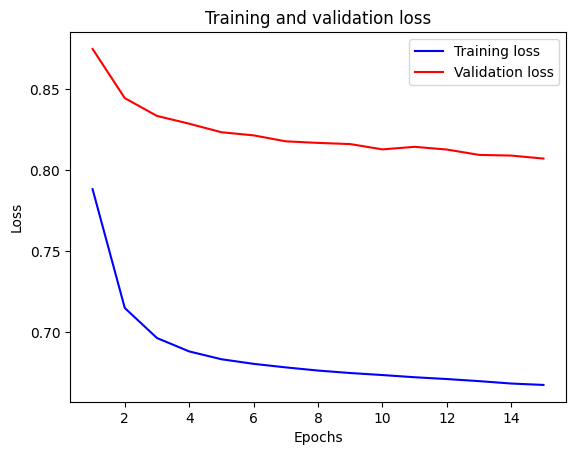

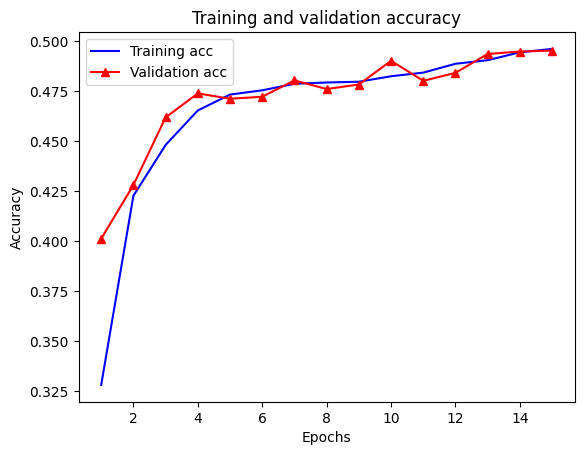

In [36]:
# VALIDATION LOSS curves

plt.clf()
history_dict = history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history_dict['loss']) + 1))
plt.plot(epochs, loss_values, 'b', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# VALIDATION ACCURACY curves

plt.clf()
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, (len(history_dict['accuracy']) + 1))
plt.plot(epochs, acc_values, 'b', label='Training acc')
plt.plot(epochs, val_acc_values, '^r-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [37]:
# Load the best model saved above during training

autoencoder = load_model('model.h5')

In [38]:
# Reconstruction error on Train

# As Train has no Fraud
y_train = np.zeros(X_train.shape[0])

predictions = autoencoder.predict(X_train)
predictions.shape

mse = np.mean(np.power(X_train - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_train})
print(error_df.shape[0], ' rows')
print('mean error of recon on TRAIN', round(error_df.reconstruction_error.mean(),2))
print('std error of recon on TRAIN', round(error_df.reconstruction_error.std(),2))

6542/6542 [==============================] - 7s 1ms/step
209315  rows
mean error of recon on TRAIN 0.67
std error of recon on TRAIN 2.4


In [39]:
# Reconstruction error on Test

predictions = autoencoder.predict(X_test)
predictions.shape

mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
print(error_df.shape[0], ' rows')
print('mean error of recon on TEST', round(error_df.reconstruction_error.mean(),2))
print('std error of recon on TEST', round(error_df.reconstruction_error.std(),2))

2360/2360 [==============================] - 2s 1ms/step
75492  rows
mean error of recon on TEST 0.81
std error of recon on TEST 3.86


In [40]:
# Reconstruction error on Fraud

# As Fraud is all Fraud
y_Fraud = np.ones(fraud_pca_data.shape[0])
y_Fraud.shape

predictions = autoencoder.predict(fraud_pca_data)
predictions.shape

mse = np.mean(np.power(fraud_pca_data - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_Fraud})
print(error_df.shape[0], ' rows')
print('mean error of recon on FRAUD', round(error_df.reconstruction_error.mean(),2))
print('std error of recon on FRAUD', round(error_df.reconstruction_error.std(),2))

16/16 [==============================] - 0s 1ms/step
492  rows
mean error of recon on FRAUD 22.1
std error of recon on FRAUD 27.97


In [41]:
# Predictions on Normal vs Fraud on Test ... using the reconstruction error as the parameter to tweak for best F1

# Reconstruction error on Test

predictions = autoencoder.predict(X_test)
predictions.shape

mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
print(error_df.shape[0], ' rows')
print('mean error of recon on TEST', round(error_df.reconstruction_error.mean(),2))
print('std error of recon on TEST', round(error_df.reconstruction_error.std(),2))

ReconError = 4.0

pred = [1 if e > ReconError else 0 for e in error_df.reconstruction_error.values]
len(pred)
#pred = (x <= eps)
f = f1_score(y_test, pred, average='binary')
print("F1 score on test", round(f,4), " with reconstruction error  ", ReconError)

2360/2360 [==============================] - 3s 1ms/step
75492  rows
mean error of recon on TEST 0.81
std error of recon on TEST 3.86
F1 score on test 0.4589  with reconstruction error   4.0


# Optimize the Reconstruction error for best F1

In [42]:
minRE = 1
maxRE = 50
    
EpsF1 = []

for TryRE in range(minRE,maxRE):
    pred = [1 if e > TryRE else 0 for e in error_df.reconstruction_error.values]
    f = f1_score(y_test, pred, average='binary')
    #print("F1 score on test", round(f,4), " with epsilon ", eps)
    EpsF1.append([TryRE, round(f,4)])
    
EpsF1df = pd.DataFrame(EpsF1, columns = ['ReconError', 'F1'])
EpsF1df.head()

,ReconError,F1
0,1,0.1053
1,2,0.2846
2,3,0.3864
3,4,0.4589
4,5,0.4566


In [43]:
# Best Recon Error ... Max F1 on test

EpsF1df.loc[EpsF1df['F1'].idxmax()]

ReconError    8.0000
F1            0.5191
Name: 7, dtype: float64

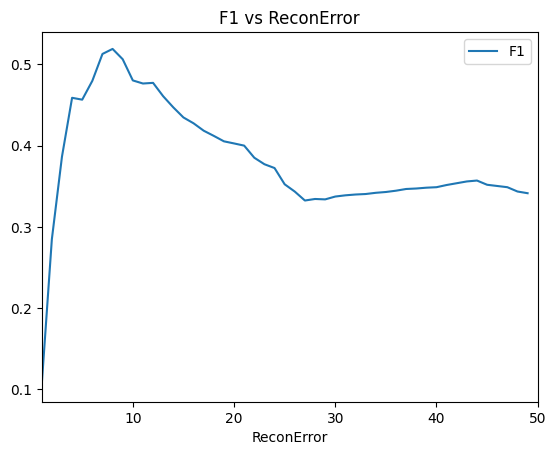

In [44]:
EpsF1df.plot.line("ReconError","F1")
plt.xlim(1, 50)
plt.title("F1 vs ReconError")
plt.show()

# Local Outlier Factor (LOF)

In [45]:
#  SCALER / Normalization

data = dfRaw.copy()
scl = StandardScaler()
all_cols = list(data)[:] 
pca_columns = list(data)[:-1] # all cols without Class
Xcopy = data[pca_columns]
XcopyALL = data[all_cols]
Xscaled = scl.fit_transform(Xcopy)
OnlyClass = data['Class'].values.reshape(-1,1)
data = np.concatenate((Xscaled, OnlyClass), axis=1)
data = pd.DataFrame(data, columns = XcopyALL.columns)

normal_data = data.loc[data["Class"] == 0]
fraud_data = data.loc[data["Class"] == 1]

print("data ", data.shape)
print("normal_data ", normal_data.shape)
print("fraud_data ", fraud_data.shape)
print("Percent fraud ", round(100*492/284807, 4),"%")

data  (284807, 31)
normal_data  (284315, 31)
fraud_data  (492, 31)
Percent fraud  0.1727 %


The following on the 75,492 test LOF w 20 neighbors takes 12 mins so for running multiple times to find the best num of neighbors - we'll reduce the test size

In [46]:
# CREATE the TRAIN and TEST sets
# Fraud data is ONLY in TEST - not in TRAIN

normal_pca_data = normal_data[pca_columns]
fraud_pca_data = fraud_data[pca_columns]

num_test = 20000
shuffled_data = normal_pca_data.sample(frac=1, random_state=1960)[:-num_test].values
X_train = shuffled_data

X_test = np.concatenate([shuffled_data[-num_test:], fraud_pca_data[:]])
y_test = np.concatenate([np.zeros(num_test), np.ones(492)])

print("normal_pca_data ", normal_pca_data.shape)
print("fraud_pca_data", fraud_pca_data.shape)
print("Fraud data only in Test with NONE in the training")
print("X_train ", X_train.shape)
#print("X_valid ", X_valid.shape)
#print("y_valid ", y_valid.shape)
print("X_test ", X_test.shape)
print("y_test ", y_test.shape)

normal_pca_data  (284315, 30)
fraud_pca_data (492, 30)
Fraud data only in Test with NONE in the training
X_train  (264315, 30)
X_test  (20492, 30)
y_test  (20492,)


In [47]:
X_inliers = shuffled_data[-num_test:]
X_outliers = fraud_pca_data[:]
X = np.r_[X_inliers, X_outliers]

n_outliers = len(X_outliers)
ground_truth = np.ones(len(X), dtype=int)
ground_truth[-n_outliers:] = -1

PercFraud = n_outliers / X_test.shape[0]
PercFraud

print('X_inliers ', X_inliers.shape)
print('X_outliers ', X_outliers.shape)
print('X ', X.shape)
print('n_outliers ', n_outliers)
print('percent fraud in test: ', PercFraud)

X_inliers  (20000, 30)
X_outliers  (492, 30)
X  (20492, 30)
n_outliers  492
percent fraud in test:  0.024009369510052704


In [48]:
%%time

# fit the model for outlier detection (default)
clf = LocalOutlierFactor(n_neighbors=20, contamination = PercFraud)
# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).
y_pred = clf.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_
n_errors

CPU times: total: 5 s
Wall time: 536 ms


934

In [49]:
print('accuracy ' , round(1 - (n_errors / X.shape[0]),4))

accuracy  0.9544


In [50]:
# Note that the ground truth and the y_pred for LOF is different than the original ... inliers = normal = 1 and outliers = fraud = -1
# We have to modify the y_pred for the F1 score calculation to be similar to the above 

y_predLOF = y_pred.copy()
y_predDF = pd.DataFrame(y_predLOF)
print(y_predDF[y_predDF[0] == -1].count())

y_predDF[y_predDF[0] == 1] = 0
y_predDF[y_predDF[0] == -1] = 1
print(y_predDF[y_predDF[0] == 1].count())

y_predLOF = y_predDF.values
y_predLOF = np.ravel(y_predLOF)


0    492
dtype: int64
0    492
dtype: int64


In [51]:
# F1 Score
#print("F1 score", round(f1_score(y_valid,pred, average='binary'), 4))
precision,recall,fbeta_score, support  = precision_recall_fscore_support(y_test, y_predLOF, average='binary')
print("precision ", round((precision), 4))
print("recall ", round((recall), 4))
print("F1 score on Test", round((fbeta_score), 4))

precision  0.0508
recall  0.0508
F1 score on Test 0.0508


In [52]:
# Optimize num of neighbors hyper paramter for best F1

minRE = 500
maxRE = 1100
    
EpsF1 = []

for TryRE in range(minRE,maxRE,100):
    clf = LocalOutlierFactor(n_neighbors=TryRE, contamination = PercFraud)
    y_pred = clf.fit_predict(X)
    n_errors = (y_pred != ground_truth).sum()
    X_scores = clf.negative_outlier_factor_
    
    y_predLOF = y_pred.copy()
    y_predDF = pd.DataFrame(y_predLOF)
    
    y_predDF[y_predDF[0] == 1] = 0
    y_predDF[y_predDF[0] == -1] = 1
    
    y_predLOF = y_predDF.values
    y_predLOF = np.ravel(y_predLOF)
    
    precision,recall,fbeta_score, support  = precision_recall_fscore_support(y_test, y_predLOF, average='binary')
    
    print("F1 score on test", round(fbeta_score,4), " with num neighbors ", TryRE)
    EpsF1.append([TryRE, round(fbeta_score,4)])
    
EpsF1df = pd.DataFrame(EpsF1, columns = ['NumNeighb', 'F1'])
EpsF1df.head()

F1 score on test 0.561  with num neighbors  500
F1 score on test 0.5915  with num neighbors  600
F1 score on test 0.6037  with num neighbors  700
F1 score on test 0.6098  with num neighbors  800
F1 score on test 0.6138  with num neighbors  900
F1 score on test 0.6037  with num neighbors  1000


,NumNeighb,F1
0,500,0.5610
1,600,0.5915
2,700,0.6037
3,800,0.6098
4,900,0.6138


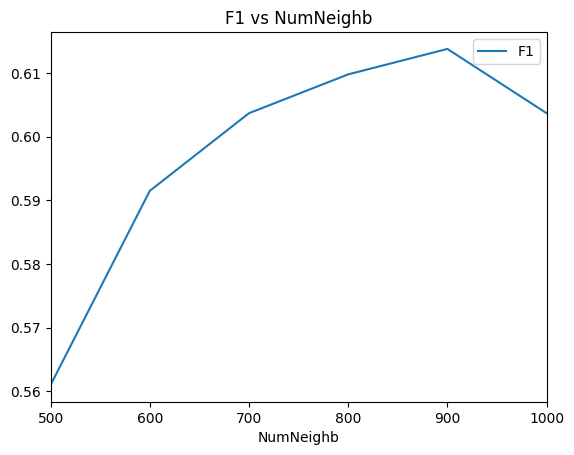

In [53]:
EpsF1df.plot.line("NumNeighb","F1")
plt.xlim(500, 1000)
plt.title("F1 vs NumNeighb")
plt.show()

Knowing that 900 is the best num of neighbors for LOF we test the original 75,492 so the results can be compared to other models
This may take 20 mins



In [54]:
data = dfRaw.copy()
scl = StandardScaler()
all_cols = list(data)[:] 
pca_columns = list(data)[:-1] # all cols without Class
Xcopy = data[pca_columns]
XcopyALL = data[all_cols]
Xscaled = scl.fit_transform(Xcopy)
OnlyClass = data['Class'].values.reshape(-1,1)
data = np.concatenate((Xscaled, OnlyClass), axis=1)
data = pd.DataFrame(data, columns = XcopyALL.columns)

normal_data = data.loc[data["Class"] == 0]
fraud_data = data.loc[data["Class"] == 1]

print("data ", data.shape)
print("normal_data ", normal_data.shape)
print("fraud_data ", fraud_data.shape)
print("Percent fraud ", round(100*492/284807, 4),"%")

# CREATE the TRAIN and TEST sets
# Fraud data is ONLY in TEST - not in TRAIN

normal_pca_data = normal_data[pca_columns]
fraud_pca_data = fraud_data[pca_columns]

num_test = 75000
shuffled_data = normal_pca_data.sample(frac=1, random_state=1960)[:-num_test].values
X_train = shuffled_data

X_test = np.concatenate([shuffled_data[-num_test:], fraud_pca_data[:]])
y_test = np.concatenate([np.zeros(num_test), np.ones(492)])

print("normal_pca_data ", normal_pca_data.shape)
print("fraud_pca_data", fraud_pca_data.shape)
print("Fraud data only in Test with NONE in the training")
print("X_train ", X_train.shape)
#print("X_valid ", X_valid.shape)
#print("y_valid ", y_valid.shape)
print("X_test ", X_test.shape)
print("y_test ", y_test.shape)

X_inliers = shuffled_data[-num_test:]
X_outliers = fraud_pca_data[:]
X = np.r_[X_inliers, X_outliers]

n_outliers = len(X_outliers)
ground_truth = np.ones(len(X), dtype=int)
ground_truth[-n_outliers:] = -1

PercFraud = n_outliers / X_test.shape[0]
PercFraud

print('X_inliers ', X_inliers.shape)
print('X_outliers ', X_outliers.shape)
print('X ', X.shape)
print('n_outliers ', n_outliers)
print('percent fraud in test: ', PercFraud)

data  (284807, 31)
normal_data  (284315, 31)
fraud_data  (492, 31)
Percent fraud  0.1727 %
normal_pca_data  (284315, 30)
fraud_pca_data (492, 30)
Fraud data only in Test with NONE in the training
X_train  (209315, 30)
X_test  (75492, 30)
y_test  (75492,)
X_inliers  (75000, 30)
X_outliers  (492, 30)
X  (75492, 30)
n_outliers  492
percent fraud in test:  0.0065172468605945


In [55]:
clf = LocalOutlierFactor(n_neighbors=900, contamination = PercFraud)

y_pred = clf.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_
#print('accuracy ' , round(1 - (n_errors / X.shape[0]),4))
n_errors

420

In [56]:
y_predLOF = y_pred.copy()
y_predDF = pd.DataFrame(y_predLOF)

y_predDF[y_predDF[0] == 1] = 0
y_predDF[y_predDF[0] == -1] = 1

y_predLOF = y_predDF.values
y_predLOF = np.ravel(y_predLOF)

# F1 Score
#print("F1 score", round(f1_score(y_valid,pred, average='binary'), 4))
precision,recall,fbeta_score, support  = precision_recall_fscore_support(y_test, y_predLOF, average='binary')
print("precision ", round((precision), 4))
print("recall ", round((recall), 4))
print("F1 score on Test", round((fbeta_score), 4))

precision  0.5732
recall  0.5732
F1 score on Test 0.5732


# Robust Covariance (Elliptic Envelope)

Requires same manipulation as LOF ... inliers = 1 and outliers = -1 while the original is normal = 0 and fraud = 1

In [57]:
#  SCALER / Normalization

data = dfRaw.copy()
scl = StandardScaler()
all_cols = list(data)[:] 
pca_columns = list(data)[:-1] # all cols without Class
Xcopy = data[pca_columns]
XcopyALL = data[all_cols]
Xscaled = scl.fit_transform(Xcopy)
OnlyClass = data['Class'].values.reshape(-1,1)
data = np.concatenate((Xscaled, OnlyClass), axis=1)
data = pd.DataFrame(data, columns = XcopyALL.columns)

normal_data = data.loc[data["Class"] == 0]
fraud_data = data.loc[data["Class"] == 1]

data = dfRaw.copy()
scl = StandardScaler()
all_cols = list(data)[:] 
pca_columns = list(data)[:-1] # all cols without Class
Xcopy = data[pca_columns]
XcopyALL = data[all_cols]
Xscaled = scl.fit_transform(Xcopy)
OnlyClass = data['Class'].values.reshape(-1,1)
data = np.concatenate((Xscaled, OnlyClass), axis=1)
data = pd.DataFrame(data, columns = XcopyALL.columns)

normal_data = data.loc[data["Class"] == 0]
fraud_data = data.loc[data["Class"] == 1]

# CREATE the TRAIN and TEST sets
# Fraud data is ONLY in TEST - not in TRAIN

normal_pca_data = normal_data[pca_columns]
fraud_pca_data = fraud_data[pca_columns]

num_test = 75000
shuffled_data = normal_pca_data.sample(frac=1, random_state=1960)[:-num_test].values
X_train = shuffled_data

X_test = np.concatenate([shuffled_data[-num_test:], fraud_pca_data[:]])
y_test = np.concatenate([np.zeros(num_test), np.ones(492)])


X_inliers = shuffled_data[-num_test:]
X_outliers = fraud_pca_data[:]
X = np.r_[X_inliers, X_outliers]

n_outliers = len(X_outliers)
ground_truth = np.ones(len(X), dtype=int)
ground_truth[-n_outliers:] = -1

PercFraud = n_outliers / X_test.shape[0]
PercFraud

print('X_inliers ', X_inliers.shape)
print('X_outliers ', X_outliers.shape)
print('X ', X.shape)
print('n_outliers ', n_outliers)
print('percent fraud in test: ', PercFraud)


X_inliers  (75000, 30)
X_outliers  (492, 30)
X  (75492, 30)
n_outliers  492
percent fraud in test:  0.0065172468605945


In [58]:
cov = EllipticEnvelope(support_fraction = 0.994, contamination = PercFraud)

y_pred = cov.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
n_errors

196

In [59]:
y_predLOF = y_pred.copy()
y_predDF = pd.DataFrame(y_predLOF)

y_predDF[y_predDF[0] == 1] = 0
y_predDF[y_predDF[0] == -1] = 1

y_predLOF = y_predDF.values
y_predLOF = np.ravel(y_predLOF)

# F1 Score
#print("F1 score", round(f1_score(y_valid,pred, average='binary'), 4))
precision,recall,fbeta_score, support  = precision_recall_fscore_support(y_test, y_predLOF, average='binary')
print("precision ", round((precision), 4))
print("recall ", round((recall), 4))
print("F1 score on Test", round((fbeta_score), 4))

precision  0.8008
recall  0.8008
F1 score on Test 0.8008


In [60]:
CM = confusion_matrix(y_test, y_predLOF)
tn, fp, fn, tp = confusion_matrix(y_test, y_predLOF).ravel()

print(CM)
print("_"*50)
print("TP ", tp)
print("FP ", fp)
print("TN ", tn)
print("FN ", fn)

[[74902    98]
 [   98   394]]
__________________________________________________
TP  394
FP  98
TN  74902
FN  98


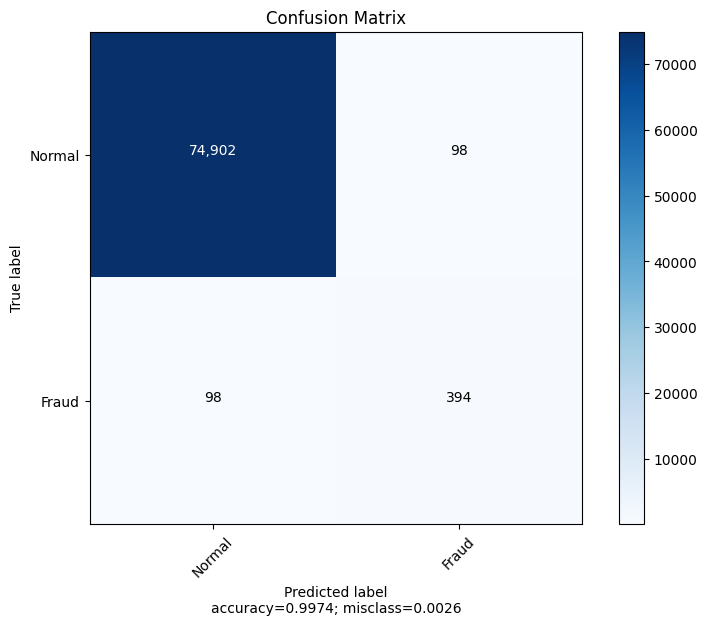

In [61]:
plot_confusion_matrix(CM, 
                      normalize    = False,
                      target_names = ['Normal', 'Fraud'],
                      title        = "Confusion Matrix")

In [62]:
# Optimize support_fraction hyper paramter for best F1

minRE = 0.95
maxRE = 0.99
    
EpsF1 = []

for TryRE in np.arange(minRE, maxRE, 0.01):
    cov = EllipticEnvelope(support_fraction = TryRE, contamination = PercFraud)
    y_pred = cov.fit_predict(X)
    n_errors = (y_pred != ground_truth).sum()
    
    y_predLOF = y_pred.copy()
    y_predDF = pd.DataFrame(y_predLOF)
    
    y_predDF[y_predDF[0] == 1] = 0
    y_predDF[y_predDF[0] == -1] = 1
    
    y_predLOF = y_predDF.values
    y_predLOF = np.ravel(y_predLOF)
    
    precision,recall,fbeta_score, support  = precision_recall_fscore_support(y_test, y_predLOF, average='binary')
    
    print("F1 score on test", round(fbeta_score,4), " with support_fraction ", TryRE)
    EpsF1.append([TryRE, round(fbeta_score,4)])
    
EpsF1df = pd.DataFrame(EpsF1, columns = ['SupFrac', 'F1'])
EpsF1df.head()

F1 score on test 0.8028  with support_fraction  0.95
F1 score on test 0.8028  with support_fraction  0.96
F1 score on test 0.8028  with support_fraction  0.97
F1 score on test 0.8028  with support_fraction  0.98
F1 score on test 0.8008  with support_fraction  0.99


,SupFrac,F1
0,0.95,0.8028
1,0.96,0.8028
2,0.97,0.8028
3,0.98,0.8028
4,0.99,0.8008


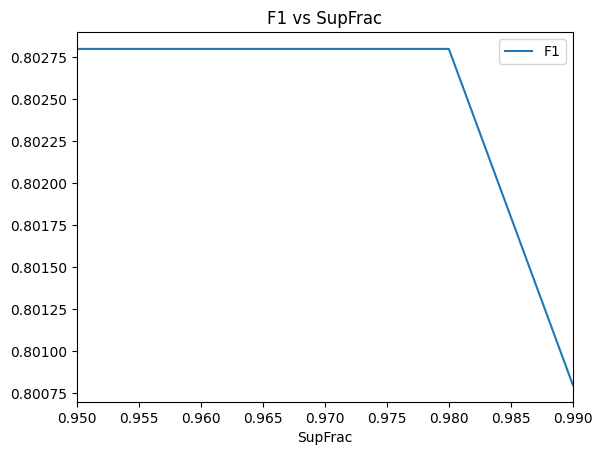

In [63]:
EpsF1df.plot.line("SupFrac","F1")
plt.xlim(minRE, maxRE)
plt.title("F1 vs SupFrac")
plt.show()

# Isolation Forest
Requires same manipulation as LOF ... inliers = 1 and outliers = -1 while the original is normal = 0 and fraud = 1

In [64]:
#  SCALER / Normalization

data = dfRaw.copy()
scl = StandardScaler()
all_cols = list(data)[:] 
pca_columns = list(data)[:-1] # all cols without Class
Xcopy = data[pca_columns]
XcopyALL = data[all_cols]
Xscaled = scl.fit_transform(Xcopy)
OnlyClass = data['Class'].values.reshape(-1,1)
data = np.concatenate((Xscaled, OnlyClass), axis=1)
data = pd.DataFrame(data, columns = XcopyALL.columns)

normal_data = data.loc[data["Class"] == 0]
fraud_data = data.loc[data["Class"] == 1]

data = dfRaw.copy()
scl = StandardScaler()
all_cols = list(data)[:] 
pca_columns = list(data)[:-1] # all cols without Class
Xcopy = data[pca_columns]
XcopyALL = data[all_cols]
Xscaled = scl.fit_transform(Xcopy)
OnlyClass = data['Class'].values.reshape(-1,1)
data = np.concatenate((Xscaled, OnlyClass), axis=1)
data = pd.DataFrame(data, columns = XcopyALL.columns)

normal_data = data.loc[data["Class"] == 0]
fraud_data = data.loc[data["Class"] == 1]

# CREATE the TRAIN and TEST sets
# Fraud data is ONLY in TEST - not in TRAIN

normal_pca_data = normal_data[pca_columns]
fraud_pca_data = fraud_data[pca_columns]

num_test = 75000
shuffled_data = normal_pca_data.sample(frac=1, random_state=1960)[:-num_test].values
X_train = shuffled_data

X_test = np.concatenate([shuffled_data[-num_test:], fraud_pca_data[:]])
y_test = np.concatenate([np.zeros(num_test), np.ones(492)])


X_inliers = shuffled_data[-num_test:]
X_outliers = fraud_pca_data[:]
X = np.r_[X_inliers, X_outliers]

n_outliers = len(X_outliers)
ground_truth = np.ones(len(X), dtype=int)
ground_truth[-n_outliers:] = -1

PercFraud = n_outliers / X_test.shape[0]
PercFraud

print('X_inliers ', X_inliers.shape)
print('X_outliers ', X_outliers.shape)
print('X ', X.shape)
print('n_outliers ', n_outliers)
print('percent fraud in test: ', PercFraud)


X_inliers  (75000, 30)
X_outliers  (492, 30)
X  (75492, 30)
n_outliers  492
percent fraud in test:  0.0065172468605945


In [65]:
isofo = IsolationForest(n_estimators = 1050, max_features = 1.0, max_samples=1.0, 
                        bootstrap=False, random_state=22,
                        contamination = PercFraud)

y_pred = isofo.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
print(n_errors)

530


In [66]:
y_predLOF = y_pred.copy()
y_predDF = pd.DataFrame(y_predLOF)

y_predDF[y_predDF[0] == 1] = 0
y_predDF[y_predDF[0] == -1] = 1

y_predLOF = y_predDF.values
y_predLOF = np.ravel(y_predLOF)

# F1 Score
#print("F1 score", round(f1_score(y_valid,pred, average='binary'), 4))
precision,recall,fbeta_score, support  = precision_recall_fscore_support(y_test, y_predLOF, average='binary')
print("precision ", round((precision), 4))
print("recall ", round((recall), 4))
print("F1 score on Test", round((fbeta_score), 4))

precision  0.4614
recall  0.4614
F1 score on Test 0.4614


In [67]:
# Optimize Num Estimators hyper paramter for best F1

minRE = 900
maxRE = 1150
    
EpsF1 = []

for TryRE in np.arange(minRE, maxRE, 50):
    isofo = IsolationForest(n_estimators = TryRE, max_features = 1.0, max_samples=1.0, 
                        warm_start=False, bootstrap=False, random_state=22,
                        contamination = PercFraud)

    y_pred = isofo.fit_predict(X)
    n_errors = (y_pred != ground_truth).sum()
    
    y_predLOF = y_pred.copy()
    y_predDF = pd.DataFrame(y_predLOF)
    
    y_predDF[y_predDF[0] == 1] = 0
    y_predDF[y_predDF[0] == -1] = 1
    
    y_predLOF = y_predDF.values
    y_predLOF = np.ravel(y_predLOF)
    
    precision,recall,fbeta_score, support  = precision_recall_fscore_support(y_test, y_predLOF, average='binary')
    
    print("F1 score on test", round(fbeta_score,4), " with num_estimators ", TryRE)
    EpsF1.append([TryRE, round(fbeta_score,4)])
    
EpsF1df = pd.DataFrame(EpsF1, columns = ['NumEstim', 'F1'])
EpsF1df.head()

F1 score on test 0.4593  with num_estimators  900
F1 score on test 0.4573  with num_estimators  950
F1 score on test 0.4573  with num_estimators  1000
F1 score on test 0.4614  with num_estimators  1050
F1 score on test 0.4614  with num_estimators  1100


,NumEstim,F1
0,900,0.4593
1,950,0.4573
2,1000,0.4573
3,1050,0.4614
4,1100,0.4614


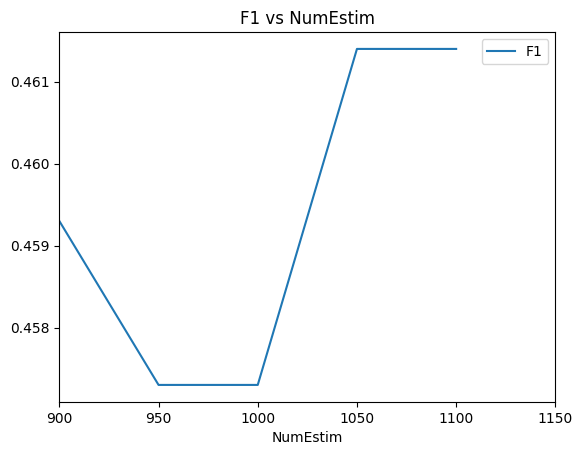

In [68]:
EpsF1df.plot.line("NumEstim","F1")
plt.xlim(minRE, maxRE)
plt.title("F1 vs NumEstim")
plt.show()